In [1]:
import re
import os 
import pandas as pd 
import numpy as np 
from scipy.stats import gmean
from matplotlib import pyplot as plt 
import seaborn as sns

In [15]:
DATAPATH = ["in-order", "out-order"]
BENCHMARKS = ["bzip2", "mcf", "hmmer", "sjeng", "milc"]
BRANCH_PRED = ["perfect", "nottaken", "bimod", "2lev (1-bit)", "2lev (4-bit)", "combined"]

def parse_file(FOLDER_NAME):
    files = list(filter(lambda x : x.endswith('.simout'),os.listdir(FOLDER_NAME)))
    stats = []
    for filename in files :
        datapath = filename.split('.')[1]
        benchmark = BENCHMARKS[int(filename.split('.')[0][0])]
        branch_predictor = BRANCH_PRED[int(filename.split('.')[0][2])]
        
        with open(os.path.join(FOLDER_NAME, filename)) as f : 
            lines = f.readlines()
            for line in lines[134:] :
                if line == '\n' :
                    continue
                stat_name, stat_val, stat_desc = line.strip().split(maxsplit=2)
                try :
                    stat_val = float(stat_val)
                except Exception as e :
                    continue
                    
                stats.append(
                    {
                    'filename' : filename,
                    'datapath' : datapath,
                    'benchmark' : benchmark, 
                    'branch_predictor' : branch_predictor,
                    'stat_name' : stat_name, 
                    'stat_desc' : stat_desc,
                    'stat_val' : stat_val
                    }
                )
    return stats 

def create_stats(stats): 
    df = pd.DataFrame(stats)

    columns = ['filename','datapath','benchmark','branch_predictor']
    CPI_NAME = ['sim_CPI']
    NUM_INST_NAME = ['sim_num_insn']
    BM_NAME = list(filter(lambda x : x.startswith('bpred_') & x.endswith('.misses'), df['stat_name'].drop_duplicates()))

    stat_df = (df
                .pivot(index=columns, 
                        columns='stat_name', 
                        values='stat_val')
                .reset_index()
                .loc[:,columns+NUM_INST_NAME+CPI_NAME+BM_NAME]
                .assign(BM=lambda x: x[BM_NAME].sum(axis=1))
                .assign(BMPI=lambda x: (x['BM']/x['sim_num_insn']))
            )

    ### Calculating Norm Value
    CPI_NORM_VAL = dict(stat_df.loc[(stat_df['datapath']=='inorder') & (stat_df['branch_predictor']=='nottaken'), ['benchmark','sim_CPI']].values)
    print(CPI_NORM_VAL)
    BMPI_NORM_VAL = dict(stat_df.loc[(stat_df['datapath']=='inorder') & (stat_df['branch_predictor']=='nottaken'), ['benchmark','BMPI']].values)
    print(BMPI_NORM_VAL)

    stat_df = (stat_df
                .assign(CPI_NORM = stat_df['sim_CPI'] / stat_df['benchmark'].map(CPI_NORM_VAL))
                .assign(BMPI_NORM = stat_df['BMPI'] / stat_df['benchmark'].map(BMPI_NORM_VAL))
            )

    ### GeoMean 
    geometric_mean = stat_df.groupby(by=['datapath','branch_predictor'], as_index=False)['sim_CPI','BM','BMPI','CPI_NORM','BMPI_NORM'].agg(lambda x: gmean(x) if sum(x)!=0 else 0)
    geometric_mean['benchmark'] = 'Geo_Mean'

    stat_df = pd.concat([stat_df, geometric_mean], ignore_index=True)

    ### Creating result
    result = stat_df[['datapath','benchmark','branch_predictor','sim_CPI','BMPI','CPI_NORM','BMPI_NORM']]

    return result

def plot_res(result, order):
    sns.set(style="whitegrid")
    for name in ['sim_CPI','BMPI','CPI_NORM','BMPI_NORM']:
        sns.catplot(x='benchmark', y=name, data=result, kind='bar', hue='branch_predictor', col='datapath', col_wrap=2, order=order)
    plt.show()


In [16]:
FOLDER_NAME = 'cse431-sim2'
stats = parse_file(FOLDER_NAME)
result = create_stats(stats)

{'bzip2': 2.3296, 'mcf': 2.3227, 'hmmer': 2.0174, 'sjeng': 2.2858, 'milc': 2.1964}
{'bzip2': 0.097429, 'mcf': 0.1077815, 'hmmer': 0.132764, 'sjeng': 0.1093025, 'milc': 0.092959}


C:\Users\risha\AppData\Local\Temp\ipykernel_14624\1180686805.py:67: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  geometric_mean = stat_df.groupby(by=['datapath','branch_predictor'], as_index=False)['sim_CPI','BM','BMPI','CPI_NORM','BMPI_NORM'].agg(lambda x: gmean(x) if sum(x)!=0 else 0)


- `datapath` :  Datapath used for simulation [inorder, outorder]   
- `benchmark` : Benchmarks [bzip2, mcf, hmmer, sjeng, milc, Geo_Mean]   
- `branch_predictor` : Branch Predictors used [perfect, nottaken, bimod, 2lev (1-bit), 2lev (4-bit), combined]   
- `sim_CPI` : Cycles per Instruction
- `BMPI` : Branch Mispredictions per Instruction
- `CPI_NORM` = CPI / CPI {`datapath` = in-order  AND `branch_prediction` = not-taken }
- `BMPI_NORM` = BMPI / BMPI {`datapath` = in-order  AND `branch_prediction` = not-taken }

In [22]:
result.head()

stat_name,datapath,benchmark,branch_predictor,sim_CPI,BMPI,CPI_NORM,BMPI_NORM
0,inorder,bzip2,perfect,1.8429,0.000000,0.791080,0.000000
1,outorder,bzip2,perfect,1.1484,0.000000,0.492960,0.000000
2,inorder,bzip2,nottaken,2.3296,0.097429,1.000000,1.000000
3,outorder,bzip2,nottaken,1.6412,0.097429,0.704499,1.000000
4,inorder,bzip2,bimod,1.8434,0.000076,0.791295,0.000775


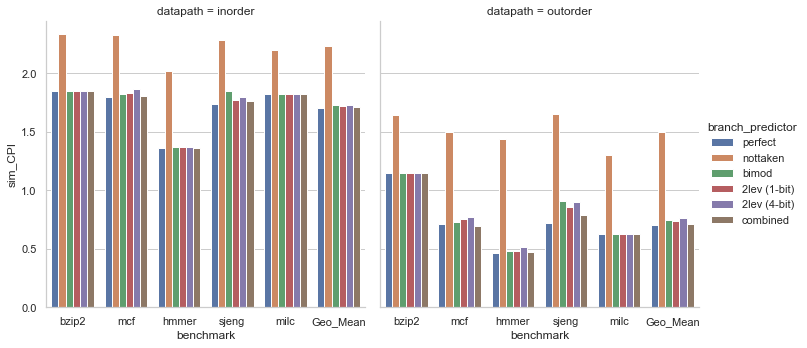

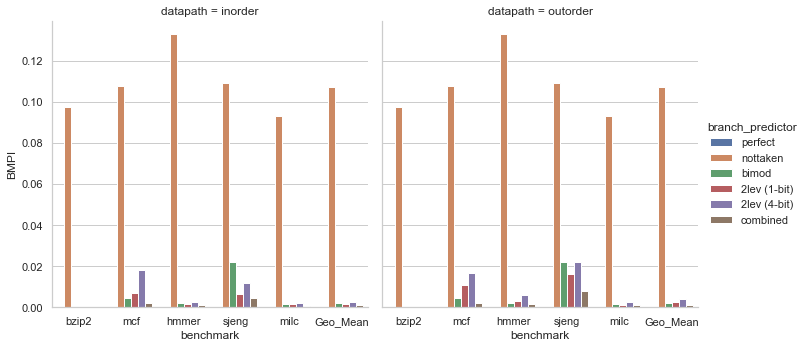

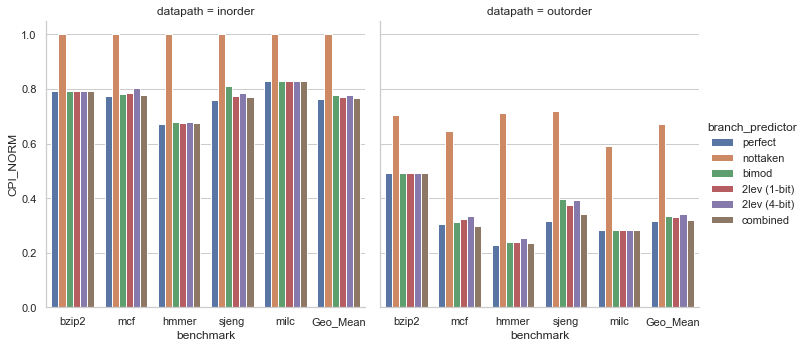

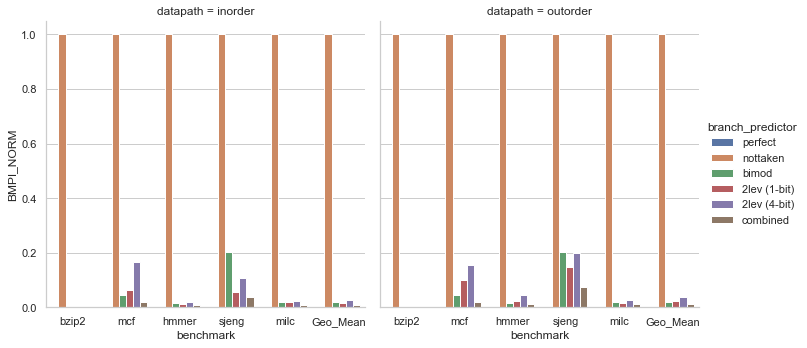

In [23]:
plot_res(result2, order=BENCHMARKS+['Geo_Mean'])